In [105]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import sys
import http.client, urllib.request, urllib.parse, urllib.error, base64
from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

#Change root to the folder where you have the data stored, AR has the group project
root = r"G:/.shortcut-targets-by-id/1hgVHDpl_iZ7es6sKW0QRlC9X6SF58wk7/Machine Learning 4 Cities Final Project"

#Change this to match your folder structure
inp= os.join(root, "Data", "3_clean_data")
out= os.join(root, "Results")


In [106]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [107]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy
Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r


In [108]:
# load codebook        
codebk = drive.CreateFile({'id': '1Lf7kV9_R-caFZV6_l8hMxAVjFSVFhvYl'})
codebk.GetContentFile('codebook.xlsx')  

codebk= pd.read_excel('codebook.xlsx', sheet_name = "predictors")
codebk.head()

C:\Users\rivera30\Anaconda3\envs\geo_env\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Variable,Description,Source,Notes,Include_BBL,Include_Box
0,geofips,census tract geo identifier,Census ACS,NaN,0,0
1,geofips_recode,"census tract geo identifier, changes county to...",Census ACS,NaN,0,0
2,totpop,total population,Census ACS,NaN,1,1
3,popdens,total population per square mile,Census ACS,NaN,1,1
4,areasqmile,area,Census ACS,NaN,1,1


In [109]:
predictors_full = codebk.loc[codebk["Include_Box"] == 1, "Variable"].apply(lambda x: x.strip())
predictors_full

2            totpop
3           popdens
4        areasqmile
5             males
6           females
           ...     
164    bldgclass_A2
165    bldgclass_A0
166    bldgclass_A6
167    bldgclass_A8
168    bldgclass_CM
Name: Variable, Length: 150, dtype: object

In [110]:
df_box = drive.CreateFile({'id': '1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy'})
df_box.GetContentFile('analysis_box.csv')  

df_box= pd.read_csv('analysis_box.csv').drop(["Unnamed: 0"], axis = 1)
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctmvdsamecounty,pctmvdsdiffcounty,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,3.130277,0.0,0.0,0.948175,1.0,3.500000,2.333333,32.666667,6,1.200000
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,3.130277,0.0,0.0,0.948175,1.0,3.000000,2.000000,42.333333,3,3.000000
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,3.130277,0.0,0.0,0.948175,1.0,3.200000,2.040000,36.880000,25,1.923077
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,3.130277,0.0,0.0,0.948175,1.0,2.400000,1.600000,15.600000,5,1.666667
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,3.130277,0.0,0.0,0.948175,1.0,3.545455,2.340909,32.181818,44,2.933333


In [111]:
len(df_box)

10864

In [112]:
assert df_box.dropna().shape[0] == df_box.shape[0]

In [113]:
len(df_box)

10864

In [114]:
outcomes= ["dispatch_response_seconds_qy", "num_fire_ev", "avg_fire_ev_yr"]
df_box[outcomes].head()

,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,32.666667,6,1.200000
1,42.333333,3,3.000000
2,36.880000,25,1.923077
3,15.600000,5,1.666667
4,32.181818,44,2.933333


In [115]:
print(df_box.columns)
df_box.describe()

Index(['borobox', 'lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'assessland', 'assesstot', 'exempttot',
       ...
       'pctmvdsamecounty', 'pctmvdsdiffcounty', 'pctmvdsdiffstate',
       'pctmvdabroad', 'pctpoprenterhh', 'engines_assigned_quantity',
       'ladders_assigned_quantity', 'dispatch_response_seconds_qy',
       'num_fire_ev', 'avg_fire_ev_yr'],
      dtype='object', length=174)


,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctmvdsamecounty,pctmvdsdiffcounty,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
count,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,1.086400e+04,10864.000000,...,1.086400e+04,10864.0,10864.0,1.086400e+04,10864.0,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.357522e+04,2.571084e+04,1.933247,3.265942,24.319713,24.943418,2.715792e+05,1.459393e+06,6.523947e+05,1936.620042,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,2.696305,1.891626,40.335653,27.951859,2.381331
std,1.175372e+05,1.833891e+05,13.499644,3.536401,175.050922,176.069510,1.863966e+06,8.148841e+06,6.698656e+06,62.844576,...,5.191642e-13,0.0,0.0,3.630596e-14,0.0,1.179745,0.752555,18.500212,48.572309,2.800509
min,5.262012e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.473684e+03,1.869000e+04,0.000000e+00,0.000000,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.657231e+03,1.837039e+03,1.066667,2.003120,1.414634,1.448040,1.375180e+04,4.607525e+04,2.226809e+03,1925.107672,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,2.090909,1.571429,32.290179,5.000000,1.200000
50%,3.586508e+03,2.774481e+03,1.218750,2.280000,2.367664,2.517241,2.153047e+04,8.708528e+04,4.093244e+03,1938.104409,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,2.909091,2.000000,40.333333,13.000000,1.666667
75%,5.214915e+03,8.144752e+03,1.464286,3.000000,7.698662,8.206375,5.787226e+04,3.684127e+05,3.452681e+04,1953.518519,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,3.312500,2.250000,49.910985,31.000000,2.538462
max,7.921386e+06,1.354011e+07,1169.000000,72.000000,10914.000000,10948.000000,1.345064e+08,4.435560e+08,4.435560e+08,2021.000000,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,23.928571,13.500000,450.000000,1288.000000,80.500000


In [116]:
df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10864 entries, 0 to 10863
Columns: 174 entries, borobox to avg_fire_ev_yr
dtypes: float64(171), int64(2), object(1)
memory usage: 14.4+ MB


In [117]:
list(df_box.columns)

['borobox',
 'lotarea',
 'bldgarea',
 'numbldgs',
 'numfloors',
 'unitsres',
 'unitstotal',
 'assessland',
 'assesstot',
 'exempttot',
 'yearbuilt',
 'holc_AB',
 'holc_CD',
 'holc_D',
 'tot_hpd_vio',
 'hpd_fire_vio',
 'hpd_b_c_vio',
 'viol_count_per_unit',
 'hpd_fire_vio_per_unit',
 'hpd_b_c_vio_per_unit',
 'AL',
 'NB',
 'average_energy_usage',
 'average_energy_usage_mi',
 'geofips_recode',
 'pcthgas',
 'pcthelectricity',
 'pcthoilker',
 'pcthcoal',
 'pcthsolar',
 'pcthotherf',
 'pcthnofuel',
 'landuse_01',
 'landuse_02',
 'landuse_03',
 'landuse_04',
 'bldgclass_C2',
 'bldgclass_C5',
 'bldgclass_D4',
 'bldgclass_C0',
 'bldgclass_A4',
 'bldgclass_C3',
 'bldgclass_S5',
 'bldgclass_R1',
 'bldgclass_C6',
 'bldgclass_C1',
 'bldgclass_R4',
 'bldgclass_D3',
 'bldgclass_B1',
 'bldgclass_B9',
 'bldgclass_D6',
 'bldgclass_C7',
 'bldgclass_RM',
 'bldgclass_K4',
 'bldgclass_A9',
 'bldgclass_S4',
 'bldgclass_A5',
 'bldgclass_C4',
 'bldgclass_S1',
 'bldgclass_B3',
 'bldgclass_C9',
 'bldgclass_O8',


In [118]:
df_box[outcomes].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10864 entries, 0 to 10863
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   dispatch_response_seconds_qy  10864 non-null  float64
 1   num_fire_ev                   10864 non-null  int64  
 2   avg_fire_ev_yr                10864 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 254.8 KB


In [119]:
# will need to discretize outcomes 
df_box.describe()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctmvdsamecounty,pctmvdsdiffcounty,pctmvdsdiffstate,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
count,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,1.086400e+04,10864.000000,...,1.086400e+04,10864.0,10864.0,1.086400e+04,10864.0,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.357522e+04,2.571084e+04,1.933247,3.265942,24.319713,24.943418,2.715792e+05,1.459393e+06,6.523947e+05,1936.620042,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,2.696305,1.891626,40.335653,27.951859,2.381331
std,1.175372e+05,1.833891e+05,13.499644,3.536401,175.050922,176.069510,1.863966e+06,8.148841e+06,6.698656e+06,62.844576,...,5.191642e-13,0.0,0.0,3.630596e-14,0.0,1.179745,0.752555,18.500212,48.572309,2.800509
min,5.262012e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.473684e+03,1.869000e+04,0.000000e+00,0.000000,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.657231e+03,1.837039e+03,1.066667,2.003120,1.414634,1.448040,1.375180e+04,4.607525e+04,2.226809e+03,1925.107672,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,2.090909,1.571429,32.290179,5.000000,1.200000
50%,3.586508e+03,2.774481e+03,1.218750,2.280000,2.367664,2.517241,2.153047e+04,8.708528e+04,4.093244e+03,1938.104409,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,2.909091,2.000000,40.333333,13.000000,1.666667
75%,5.214915e+03,8.144752e+03,1.464286,3.000000,7.698662,8.206375,5.787226e+04,3.684127e+05,3.452681e+04,1953.518519,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,3.312500,2.250000,49.910985,31.000000,2.538462
max,7.921386e+06,1.354011e+07,1169.000000,72.000000,10914.000000,10948.000000,1.345064e+08,4.435560e+08,4.435560e+08,2021.000000,...,3.130277e+00,0.0,0.0,9.481751e-01,1.0,23.928571,13.500000,450.000000,1288.000000,80.500000


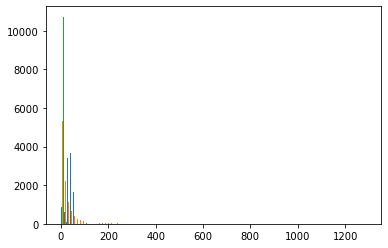

In [120]:
#outcome vars
plt.hist(df_box.loc[:, outcomes], bins = 100);


In [121]:
outcomes

['dispatch_response_seconds_qy', 'num_fire_ev', 'avg_fire_ev_yr']

In [122]:
df_box['dispatch_cat'] = pd.qcut(df_box["dispatch_response_seconds_qy"],4, labels=False)

In [123]:
df_box['num_fire_ev_cat'] = pd.qcut(df_box["num_fire_ev"], 4, labels=False)

In [124]:
df_box['avg_fire_ev_yr_cat'] = pd.qcut(df_box["avg_fire_ev_yr"], 4, labels=False)

In [125]:
df_box.describe()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctmvdabroad,pctpoprenterhh,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,dispatch_cat,num_fire_ev_cat,avg_fire_ev_yr_cat
count,1.086400e+04,1.086400e+04,10864.000000,10864.000000,10864.000000,10864.000000,1.086400e+04,1.086400e+04,1.086400e+04,10864.000000,...,1.086400e+04,10864.0,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.357522e+04,2.571084e+04,1.933247,3.265942,24.319713,24.943418,2.715792e+05,1.459393e+06,6.523947e+05,1936.620042,...,9.481751e-01,1.0,2.696305,1.891626,40.335653,27.951859,2.381331,1.499632,1.470453,1.487113
std,1.175372e+05,1.833891e+05,13.499644,3.536401,175.050922,176.069510,1.863966e+06,8.148841e+06,6.698656e+06,62.844576,...,3.630596e-14,0.0,1.179745,0.752555,18.500212,48.572309,2.800509,1.118085,1.134940,1.123268
min,5.262012e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.473684e+03,1.869000e+04,0.000000e+00,0.000000,...,9.481751e-01,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.657231e+03,1.837039e+03,1.066667,2.003120,1.414634,1.448040,1.375180e+04,4.607525e+04,2.226809e+03,1925.107672,...,9.481751e-01,1.0,2.090909,1.571429,32.290179,5.000000,1.200000,0.750000,0.000000,0.000000
50%,3.586508e+03,2.774481e+03,1.218750,2.280000,2.367664,2.517241,2.153047e+04,8.708528e+04,4.093244e+03,1938.104409,...,9.481751e-01,1.0,2.909091,2.000000,40.333333,13.000000,1.666667,1.000000,1.000000,1.000000
75%,5.214915e+03,8.144752e+03,1.464286,3.000000,7.698662,8.206375,5.787226e+04,3.684127e+05,3.452681e+04,1953.518519,...,9.481751e-01,1.0,3.312500,2.250000,49.910985,31.000000,2.538462,2.250000,2.000000,2.000000
max,7.921386e+06,1.354011e+07,1169.000000,72.000000,10914.000000,10948.000000,1.345064e+08,4.435560e+08,4.435560e+08,2021.000000,...,9.481751e-01,1.0,23.928571,13.500000,450.000000,1288.000000,80.500000,3.000000,3.000000,3.000000


In [126]:
df_box.dispatch_cat.value_counts()

1    2720
0    2716
3    2716
2    2712
Name: dispatch_cat, dtype: int64

In [127]:
df_box.num_fire_ev_cat.value_counts()

0    2929
3    2714
2    2612
1    2609
Name: num_fire_ev_cat, dtype: int64

In [128]:
df_box['fire_ev_dummy'] = np.where(df_box['num_fire_ev_cat'] == 3, 1, 0)


In [129]:
df_box.fire_ev_dummy.value_counts()

0    8150
1    2714
Name: fire_ev_dummy, dtype: int64

In [130]:
df_box['dispatch_dummy'] = np.where(df_box['dispatch_cat'] == 3, 1, 0)
df_box.dispatch_dummy.value_counts()

0    8148
1    2716
Name: dispatch_dummy, dtype: int64

In [131]:
df_box['avg_fire_ev_dummy'] = np.where(df_box['avg_fire_ev_yr_cat'] == 3, 1, 0)
df_box.avg_fire_ev_dummy.value_counts()

0    8149
1    2715
Name: avg_fire_ev_dummy, dtype: int64

In [132]:
# Predictors important using LASSO
predictors_fimp=["viol_count_per_unit", "popdens", "popnhblack", "numfloors", "hpd_fire_vio", "roc_half_1", "holc_D", 
                 "hhfoilkerosene", "hpd_fire_vio_per_unit", "average_energy_usage_mi"] 

In [133]:
df_box[predictors_fimp].describe()

,viol_count_per_unit,popdens,popnhblack,numfloors,hpd_fire_vio,roc_half_1,holc_D,hhfoilkerosene,hpd_fire_vio_per_unit,average_energy_usage_mi
count,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,1.079967,10037.962656,168.575203,3.265942,0.118618,85.919183,0.257309,51.302007,0.006959,0.917187
std,1.650103,15227.719916,338.141482,3.536401,0.412708,131.655617,0.415144,100.784807,0.017631,0.206218
min,0.000000,0.896238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.088535,991.145257,5.394486,2.003120,0.000000,10.523511,0.000000,5.359079,0.000000,0.959184
50%,0.464748,4301.131657,30.895632,2.280000,0.000000,37.924577,0.000000,15.430936,0.000000,1.000000
75%,1.321379,13322.254835,177.378453,3.000000,0.055227,111.958125,0.568167,49.648682,0.004880,1.000000
max,22.872340,249780.202465,8843.153846,72.000000,19.000000,3058.238095,1.000000,1598.958059,0.333333,1.000000


### Use Naive Bayes Classifier to predict fire events, dispatch response per alarm box

In [134]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split


In [135]:
X = df_box.loc[:, predictors_fimp].fillna(0)
y = df_box.loc[:, "fire_ev_dummy"].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [136]:
def trainGaussianNaiveBayes(X,y):
    prior = 1.*y.sum()/y.count()
    nbc = {'prior':prior}
    X_1 = X[y==1]
    X_0 = X[y==0]
    for j in X.columns:
        nbc[j+'_mu1'] = X_1[j].mean()
        nbc[j+'_sigma1'] = X_1[j].std()
        nbc[j+'_mu0'] = X_0[j].mean()
        nbc[j+'_sigma0'] = X_0[j].std()
    return nbc

def testGaussianNaiveBayes(X,nbc):
    y_pred = pd.Series(index=X.index,dtype='float64')
    for i in X.index:
        # compute odds of y=1
        y_pred[i] = nbc['prior']/(1-nbc['prior']) # prior odds
        for j in X.columns:
            thevalue = X.loc[i,j]
            pdf1 = stats.norm.pdf(thevalue,loc=nbc[j+'_mu1'],scale=nbc[j+'_sigma1'])
            pdf0 = stats.norm.pdf(thevalue,loc=nbc[j+'_mu0'],scale=nbc[j+'_sigma0'])
            y_pred[i] = y_pred[i]*pdf1/pdf0 if pdf0 > 0 else 1E10
        # convert odds to probability of y=1
        y_pred[i] = y_pred[i]/(1.0+y_pred[i])
    return y_pred

In [137]:
naive_bayes_classifier = trainGaussianNaiveBayes(X_train,y_train)
for i,j in naive_bayes_classifier.items():
    print(i)
    print(j)
    print()
y_pred_train = testGaussianNaiveBayes(X_train,naive_bayes_classifier)
y_pred_test = testGaussianNaiveBayes(X_test,naive_bayes_classifier)

# measure accuracy for the binary prediction task
print('In sample prediction accuracy:',1.0*sum((y_pred_train>0.5)==y_train)/len(y_train))
print('Out of sample prediction accuracy:',1.0*sum((y_pred_test>0.5)==y_test)/len(y_test))

prior
0.25822287677957784

viol_count_per_unit_mu1
2.1350148363359507

viol_count_per_unit_sigma1
2.0761884905207997

viol_count_per_unit_mu0
0.700066094196945

viol_count_per_unit_sigma0
1.241241959739763

popdens_mu1
21562.458417340047

popdens_sigma1
21679.7742187813

popdens_mu0
6208.254779476982

popdens_sigma0
9767.608211449706

popnhblack_mu1
368.5705971714329

popnhblack_sigma1
506.26723064235773

popnhblack_mu0
101.46803156030684

popnhblack_sigma0
209.90859271081365

numfloors_mu1
4.206862058318627

numfloors_sigma1
3.347910958298378

numfloors_mu0
2.9202094575108224

numfloors_sigma0
3.430517390875406

hpd_fire_vio_mu1
0.30997655282611947

hpd_fire_vio_sigma1
0.5440551972775298

hpd_fire_vio_mu0
0.05079529943237393

hpd_fire_vio_sigma0
0.3396021411945136

roc_half_1_mu1
180.36984402089843

roc_half_1_sigma1
183.5433795027004

roc_half_1_mu0
52.927444410424435

roc_half_1_sigma0
79.36046077806883

holc_D_mu1
0.39708513655597966

holc_D_sigma1
0.4658192511378176

holc_D_mu0
0.

In [138]:
# measure accuracy for the binary prediction task
print('In sample prediction accuracy:',1.0*sum((y_pred_train>0.5)==y_train)/len(y_train))
print('Out of sample prediction accuracy:',1.0*sum((y_pred_test>0.5)==y_test)/len(y_test))

In sample prediction accuracy: 0.8140648011782032
Out of sample prediction accuracy: 0.8262150220913107


In [139]:
#Calculate precision and recall
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, (y_pred_test > 0.5))

(array([0.87271898, 0.63167939]),
 array([0.90835708, 0.54262295]),
 array([0.89018148, 0.58377425]),
 array([2106,  610], dtype=int64))

In [140]:
pr= precision_recall_fscore_support(y_test, y_pred_test > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

Precision: 0.6316793893129771
Recall: 0.5426229508196722


In [141]:
from sklearn.metrics import roc_auc_score

# predict_proba predicts the probability of each class rather than just the most likely class

#print("ROC AUC:", roc_auc_score(np.array(y_test.head(20000)),y_pred_test))

print("ROC AUC:", roc_auc_score(np.array(y_test),y_pred_test))

ROC AUC: 0.8677657901701618


In [142]:
y_pred_all = testGaussianNaiveBayes(X,naive_bayes_classifier)

In [143]:
## create a csv of probabilities at the box level and tract level
pred_prob_allbox= pd.concat([df_box.loc[:, ["borobox"]], 
                            pd.DataFrame(y_pred_all,
                                        columns = ["prob_vacate_box"])], axis = 1)
pred_prob_allbox

,borobox,prob_vacate_box
0,B0020,0.002745
1,B0023,0.002619
2,B0024,0.005272
3,B0025,0.001620
4,B0027,0.641603
...,...,...
10859,X4978,0.002087
10860,X4981,0.001059
10861,X4982,0.000175
10862,X4985,0.000189


In [144]:
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,dispatch_cat,num_fire_ev_cat,avg_fire_ev_yr_cat,fire_ev_dummy,dispatch_dummy,avg_fire_ev_dummy
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,2.333333,32.666667,6,1.200000,1,1,0,0,0,0
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,2.000000,42.333333,3,3.000000,2,0,3,0,0,1
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,2.040000,36.880000,25,1.923077,1,2,2,0,0,0
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,1.600000,15.600000,5,1.666667,0,0,1,0,0,0
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,2.340909,32.181818,44,2.933333,0,3,3,1,0,1


In [145]:
pred_prob_allbox.to_csv(os.join(out, "pred_prob_naivebayes_box.csv"))


In [146]:
y_pred_all.describe()

count    10864.000000
mean         0.200733
std          0.376529
min          0.000136
25%          0.000194
50%          0.000830
75%          0.073216
max          1.000000
dtype: float64

In [147]:
pred_prob_allbox[(pred_prob_allbox['prob_vacate_box']==1)].count()

borobox            375
prob_vacate_box    375
dtype: int64

In [148]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
trained_model = gnb.fit(X_train,y_train)
y_pred_train = trained_model.predict_proba(X_train)[:,1]
y_pred_test = trained_model.predict_proba(X_test)[:,1]

In [149]:
y_pred_test

array([0.0009646 , 0.00110056, 0.00114641, ..., 0.00202025, 0.02604623,
       0.00627787])

In [150]:
y_pred_all2 = trained_model.predict_proba(X)[:,1]

In [151]:
df = pd.DataFrame(y_pred_all2, columns = ['y_pred_all2'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10864 entries, 0 to 10863
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   y_pred_all2  10864 non-null  float64
dtypes: float64(1)
memory usage: 85.0 KB


In [152]:
y_pred_all.describe()


count    10864.000000
mean         0.200733
std          0.376529
min          0.000136
25%          0.000194
50%          0.000830
75%          0.073216
max          1.000000
dtype: float64

In [153]:
df[(df['y_pred_all2']==1)].count()

y_pred_all2    319
dtype: int64

In [154]:
y_pred_all.head()


0    0.002745
1    0.002619
2    0.005272
3    0.001620
4    0.641603
dtype: float64

In [155]:
y_pred_all2

array([0.00388045, 0.00544472, 0.00577068, ..., 0.00093334, 0.00100898,
       0.00100209])

In [156]:
pd.concat([y_pred_all, df], axis=1)

,0,y_pred_all2
0,0.002745,0.003880
1,0.002619,0.005445
2,0.005272,0.005771
3,0.001620,0.003987
4,0.641603,0.120532
...,...,...
10859,0.002087,0.007419
10860,0.001059,0.001909
10861,0.000175,0.000933
10862,0.000189,0.001009


In [165]:
# Feature importance using decision tree 
predictors_fimp2=["popdens", "popnhblack", "hpd_fire_vio", "unitsres", "popnhasian", "hpd_b_c_vio", 
                  "unitstotal", "exempttot", "tot_hpd_vio"] 

In [166]:
X = df_box.loc[:, predictors_fimp2].fillna(0)
y = df_box.loc[:, "fire_ev_dummy"].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [167]:
naive_bayes_classifier = trainGaussianNaiveBayes(X_train,y_train)
for i,j in naive_bayes_classifier.items():
    print(i)
    print(j)
    print()
y_pred_train = testGaussianNaiveBayes(X_train,naive_bayes_classifier)
y_pred_test = testGaussianNaiveBayes(X_test,naive_bayes_classifier)

# measure accuracy for the binary prediction task
print('In sample prediction accuracy:',1.0*sum((y_pred_train>0.5)==y_train)/len(y_train))
print('Out of sample prediction accuracy:',1.0*sum((y_pred_test>0.5)==y_test)/len(y_test))

prior
0.25822287677957784

popdens_mu1
21562.458417340047

popdens_sigma1
21679.7742187813

popdens_mu0
6208.254779476982

popdens_sigma0
9767.608211449706

popnhblack_mu1
368.5705971714329

popnhblack_sigma1
506.26723064235773

popnhblack_mu0
101.46803156030684

popnhblack_sigma0
209.90859271081365

hpd_fire_vio_mu1
0.30997655282611947

hpd_fire_vio_sigma1
0.5440551972775298

hpd_fire_vio_mu0
0.05079529943237393

hpd_fire_vio_sigma0
0.3396021411945136

unitsres_mu1
37.281370920994036

unitsres_sigma1
158.2497794077419

unitsres_mu0
18.282988575382763

unitsres_sigma0
139.7490769081134

popnhasian_mu1
126.26374066525534

popnhasian_sigma1
248.76781272300857

popnhasian_mu0
101.10558206449655

popnhasian_sigma0
191.36303206127548

hpd_b_c_vio_mu1
29.911115284477695

hpd_b_c_vio_sigma1
82.84096897904185

hpd_b_c_vio_mu0
5.23835005713752

hpd_b_c_vio_sigma0
32.551011283561095

unitstotal_mu1
37.99184986538759

unitstotal_sigma1
158.56317424541592

unitstotal_mu0
18.881096074252703

unitst

C:\Users\rivera30\AppData\Local\Temp\ipykernel_24836\1594424590.py:22: RuntimeWarning: overflow encountered in double_scalars
  y_pred[i] = y_pred[i]*pdf1/pdf0 if pdf0 > 0 else 1E10
C:\Users\rivera30\AppData\Local\Temp\ipykernel_24836\1594424590.py:24: RuntimeWarning: invalid value encountered in double_scalars
  y_pred[i] = y_pred[i]/(1.0+y_pred[i])


In sample prediction accuracy: 0.7963917525773195
Out of sample prediction accuracy: 0.8269513991163475


In [168]:
# measure accuracy for the binary prediction task
print('In sample prediction accuracy:',1.0*sum((y_pred_train>0.5)==y_train)/len(y_train))
print('Out of sample prediction accuracy:',1.0*sum((y_pred_test>0.5)==y_test)/len(y_test))

In sample prediction accuracy: 0.7963917525773195
Out of sample prediction accuracy: 0.8269513991163475


In [169]:
#Calculate precision and recall
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, (y_pred_test > 0.5))

(array([0.84808511, 0.69125683]),
 array([0.94634378, 0.4147541 ]),
 array([0.89452424, 0.51844262]),
 array([2106,  610], dtype=int64))

In [170]:
pr= precision_recall_fscore_support(y_test, y_pred_test > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

Precision: 0.6912568306010929
Recall: 0.41475409836065574


In [174]:
from sklearn.metrics import roc_auc_score

# predict_proba predicts the probability of each class rather than just the most likely class

#print("ROC AUC:", roc_auc_score(np.array(y_test.head(20000)),y_pred_test))

print("ROC AUC:", roc_auc_score(np.array(y_test),y_pred_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Dispatch time

In [ ]:
X = df_box.loc[:, predictors_fimp].fillna(0)
y = df_box.loc[:, "fire_ev_dummy"].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [ ]:
X = df_box.loc[:, predictors_fimp].fillna(0)
y = df_box.loc[:, "fire_ev_dummy"].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [ ]:
naive_bayes_classifier = trainGaussianNaiveBayes(X_train,y_train)
for i,j in naive_bayes_classifier.items():
    print(i)
    print(j)
    print()
#y_pred_train = testGaussianNaiveBayes(X_train,naive_bayes_classifier)
y_pred_test = testGaussianNaiveBayes(X_test,naive_bayes_classifier)

# measure accuracy for the binary prediction task
#print('In sample prediction accuracy:',1.0*sum((y_pred_train>0.5)==y_train)/len(y_train))
print('Out of sample prediction accuracy:',1.0*sum((y_pred_test>0.5)==y_test)/len(y_test))

In [ ]:
# measure accuracy for the binary prediction task
print('Out of sample prediction accuracy:',1.0*sum((y_pred_test>0.5)==y_test)/len(y_test))

# measure accuracy of the predicted probabilities
print('Log-likelihood (test):', np.log(y_pred_test*y_test + (1-y_pred_test)*(1-y_test)).replace([np.inf, -np.inf], np.nan).sum())

In [ ]:
#Calculate precision and recall
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, (y_pred_test > 0.5))